# Catchment delineation
In this Notebook, using a DEM we aim to delineate the area—referred to as a catchment, watershed, or basin—that drains or contributes water to a specific point known as the catchment outlet. This will be our area of study from now on.

<left><img src="images/catchment.png" width="800px">

## Import (or load) the necessary libraries and iMPACT-tools
These tools will let us delineate and plot the catchment and save the results.
##### Step 1: `Import tools`

In [1]:
from ipywidgets import fixed, interactive
import pandas as pd
# Import the necessary iMPACT-tools
from tools.catchment_delineation import catchment_delineation, plot_catchment_delineation
from tools.file_IO import open_raster, save_as_raster
from tools.plot_dem import plot3d_dem
from tools.dem_analysis import slope_gradient
from tools.flow_accumulation import flow_accumulation_D8, flow_accumulation_Dinf

To visualize, copy, or edit the code of these tools, write the name of the tool followed by `??`.
For example, to see the code of `catchment_delineation`, uncomment the line below and run the cell:

In [2]:
#catchment_delineation??

You can also find these tools in the Python files stored in the */tools* folder
## Function for catchment delineation
In simple terms, the function helps you understand how water flows over a landscape (DEM) and shows you the exact area that will contribute water to a particular outlet.
1. **Define outlet**: first we define a specific point on the map where the water flows out, called the catchment "outlet." 
2. **Trace the water flow**: beginning at the outlet, the function looks at all the nearby areas to check which ones flow towards the outlet, or in other words, it looks for cells of the DEM that are connected to the outlet. 
3. **Mark the catchment cells**: when the function finds a cell where water flows towards the outlet, it marks that cell as part of the catchment. 
4. **Keep Exploring**: it then continues to check the neighboring cells.
5. **Delineation of the catchment area**: once all cells have been checked, the function gives you a final map. This map shows you the entire catchment area – all the land that will drain water into the outlet.

## Load the DEM, flow direction and flow accumulation of the area of study

<left><img src="images/open_raster.png" width="200px">
##### Step 2: `Open the files and plot: DEM, flow direction and flow accumulation maps`

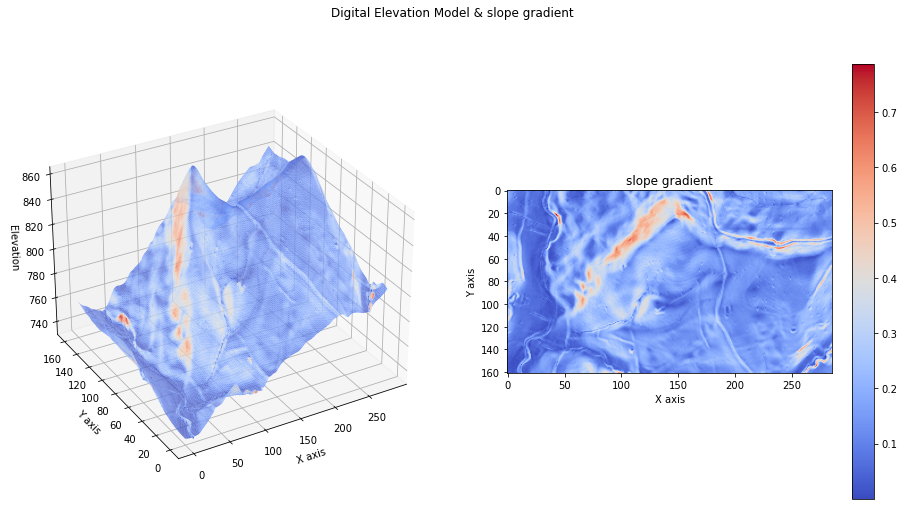

In [5]:
dem, dem_metadata = open_raster('inputs/dem/','filled_dem.tif')
dem_resol= dem_metadata['transform'][0]
slope = slope_gradient(dem, dem_resol)
plot3d_dem(dem,slope,'slope gradient')

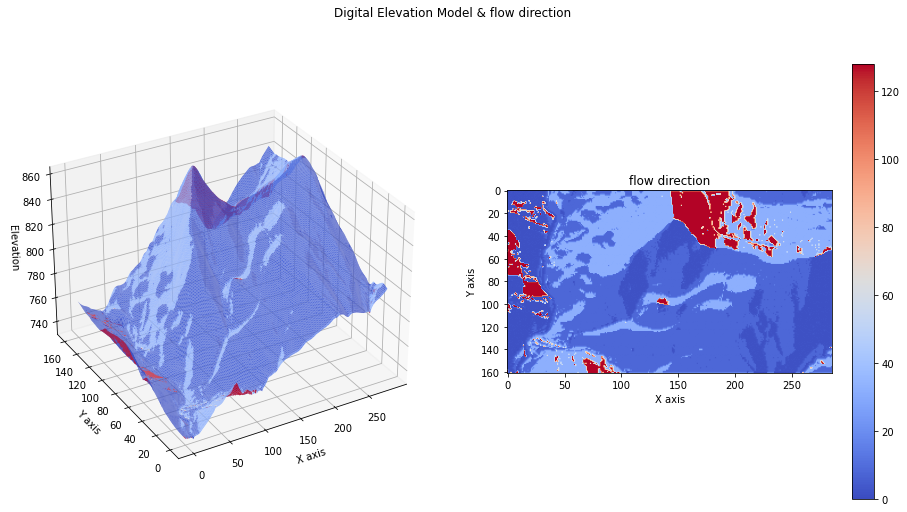

In [6]:
flow_dir_D8,flow_acc_D8,flow_rout_up_row_D8, flow_rout_up_col_D8, flow_rout_down_row_D8, flow_rout_down_col_D8, flow_rout_contrib_D8, flow_rout_slope_D8 = flow_accumulation_D8(dem,slope,dem_resol)
# Plot the 3D DEM with flow direction
plot3d_dem(dem,flow_dir_D8,'flow direction')

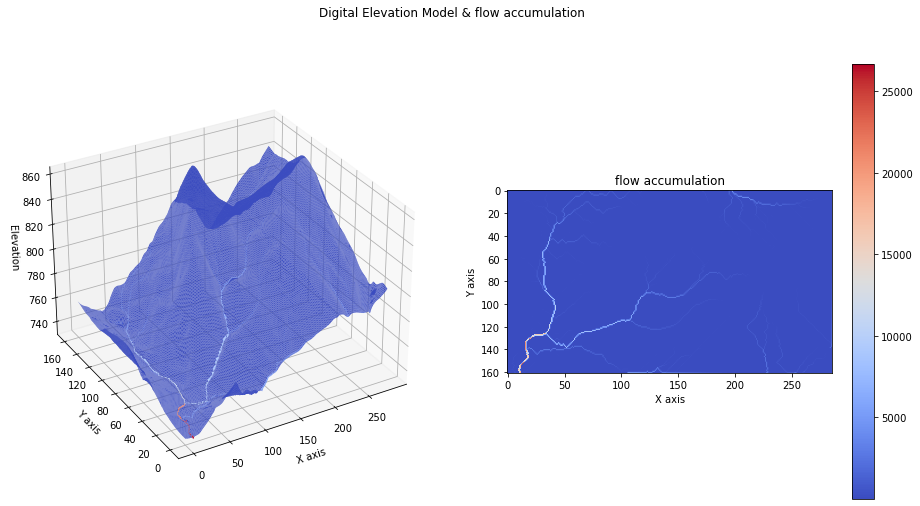

In [7]:
# Plot the 3D DEM with flow accumulation
plot3d_dem(dem,flow_acc_D8,'flow accumulation')

## Interactive plotting function for catchment delineation
In this section, we provide an interactive tool to visualize the catchment delineation process. This interactive widget allows you to select the catchment outlet using a slider. By adjusting this slider, you can see how the catchment area changes based on the outlet's position.

<left><img src="images/catchment_delineation.png" width="400px">

##### Step 3: `Interactive catchment delineation: using the slider select the catchment outlet`

In [8]:
# Interactive plot with widgets (sliders) for selecting the catchment outlet
iplot = interactive(plot_catchment_delineation,dem = fixed(dem), fd = fixed(flow_dir_D8), fa = fixed(flow_acc_D8),outlet = (1,400))
display(iplot)

interactive(children=(IntSlider(value=1, description='outlet', max=400, min=1), Output()), _dom_classes=('widg…

## Run the function to compute the slope gradient of the delineated catchment
##### Step 4: `Calculate the slope gradient of the DEM`

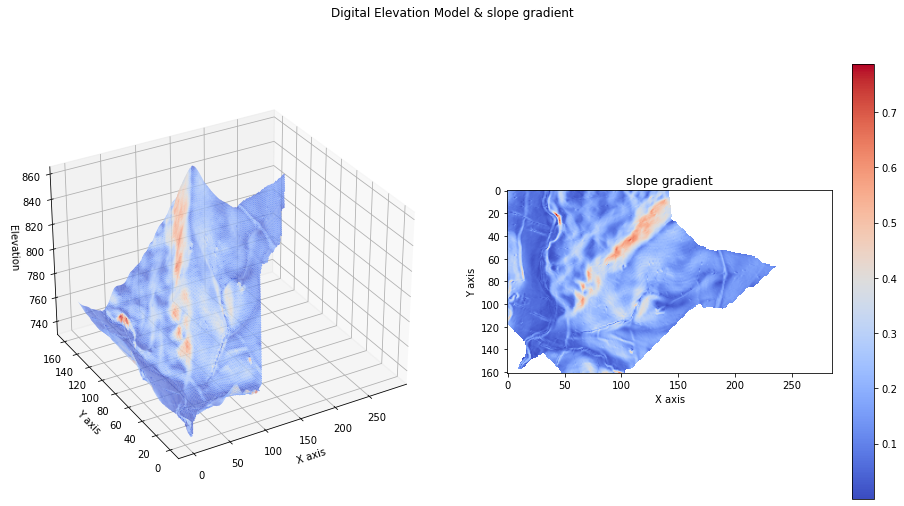

In [9]:
catchment_mask,catchment_dem = iplot.result
slope = slope_gradient(catchment_dem, dem_resol)
# Plot the 3D DEM with slope gradients
plot3d_dem(dem,slope,'slope gradient')

## Run the function to compute the slope, flow accumulation, flow direction and flow routing for the delineated catchment
Here we use the D8 method
##### Step 5a: `Run the D8 function`

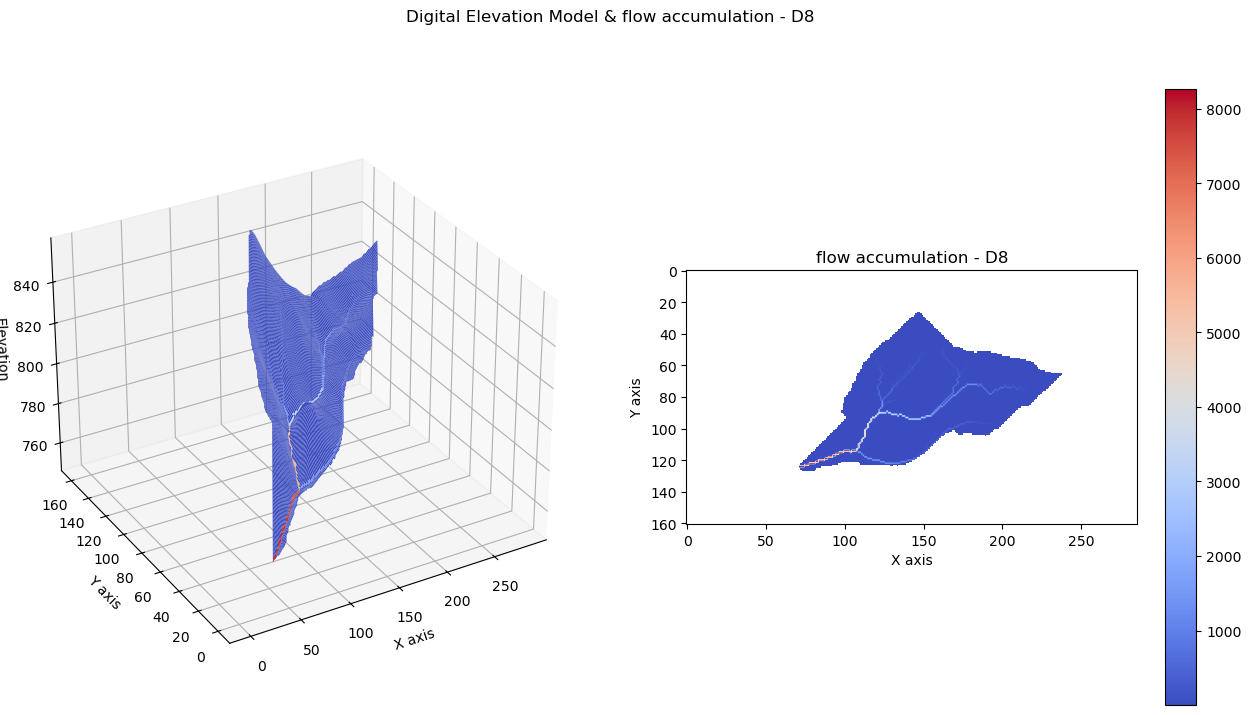

In [8]:
flow_dir_D8,flow_acc_D8,flow_rout_up_row_D8, flow_rout_up_col_D8, flow_rout_down_row_D8, flow_rout_down_col_D8, flow_rout_contrib_D8, flow_rout_slope_D8 = flow_accumulation_D8(catchment_dem,slope,dem_resol)
plot3d_dem(catchment_dem,flow_acc_D8,'flow accumulation - D8')

##### Step 5b: `Run the Dinf function`

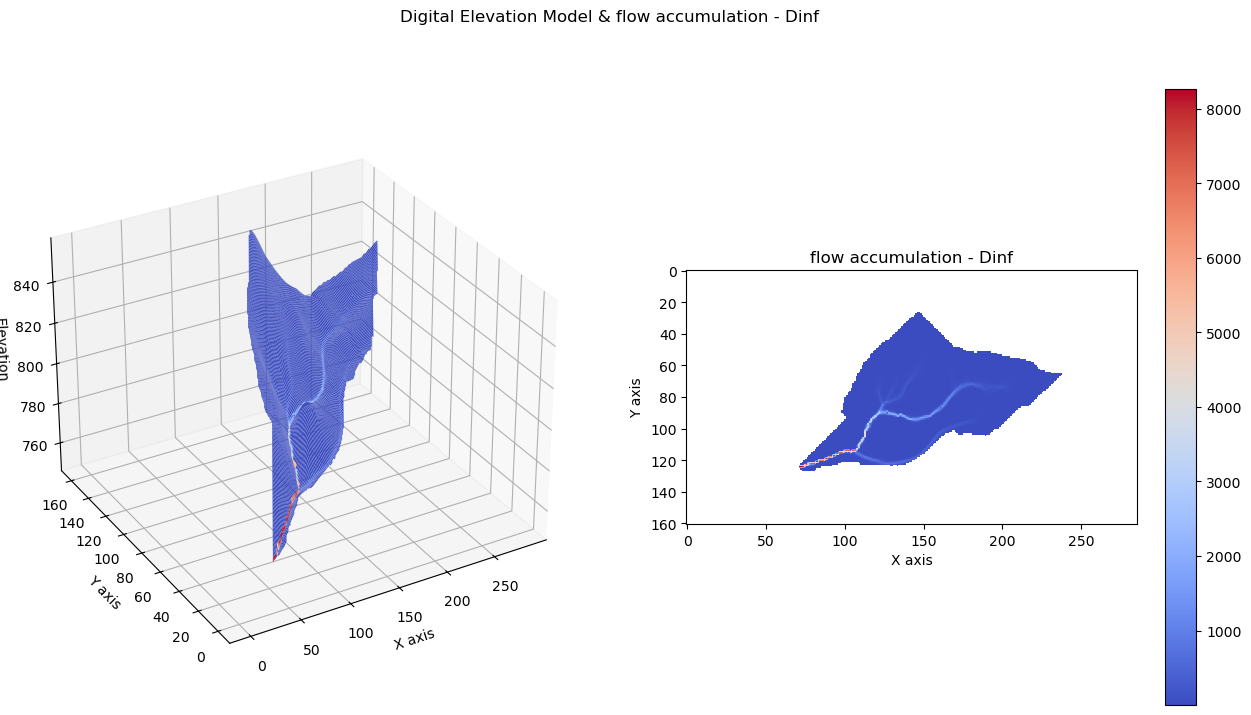

In [9]:
flow_acc_Dinf,flow_rout_up_row_Dinf,flow_rout_up_col_Dinf,flow_rout_down_row_Dinf, flow_rout_down_col_Dinf, flow_rout_contrib_Dinf, flow_rout_slope_Dinf = flow_accumulation_Dinf(catchment_dem,dem_resol)
plot3d_dem(catchment_dem,flow_acc_Dinf,'flow accumulation - Dinf')

## Save the DEM, flow accumulation and flow direction maps of the delineated catchment as a raster file and the flow routing arrays as csv files
<left><img src="images/save_raster.png" width="200px">
##### Step 6: `Save the results`

In [10]:
file_name = 'catchment_dem'
# Save the DEM as raster (TIFF) files
save_as_raster('inputs/dem/',file_name + '.tif',catchment_dem,dem_metadata)
# Save the slope, flow direction, and flow accumulation maps as raster (TIFF) files
save_as_raster('inputs/slope/','slope_' + file_name + '.tif', slope, dem_metadata)
save_as_raster('inputs/flow_dir/','flow_dir_D8_' + file_name + '.tif', flow_dir_D8, dem_metadata)
save_as_raster('inputs/flow_acc/','flow_acc_D8_' + file_name + '.tif', flow_acc_D8, dem_metadata)
save_as_raster('inputs/flow_acc/','flow_acc_Dinf_' + file_name + '.tif', flow_acc_Dinf, dem_metadata)

# Save the D8 flow routing data to a CSV file
df_D8 = pd.DataFrame() 
df_D8['upstream_row'] = flow_rout_up_row_D8   # Row indices of upstream cells for D8 method
df_D8['upstream_col'] = flow_rout_up_col_D8   # Column indices of upstream cells for D8 method
df_D8['downstream_row'] = flow_rout_down_row_D8  # Row indices of downstream cells for D8 method
df_D8['downstream_col'] = flow_rout_down_col_D8  # Column indices of downstream cells for D8 method
df_D8['contribution'] = flow_rout_contrib_D8   # Flow contributions from upstream to downstream cells
df_D8['slope'] = flow_rout_slope_D8 + [0]   # Slope values along the flow paths for D8 (added [0] to match length)
df_D8.to_csv('inputs/flow_rout/flow_routing_D8_' + file_name + '.csv', index=False)  # Export the DataFrame to a CSV file

# Save the D-infinity flow routing data to a CSV file
df_Dinf = pd.DataFrame()
df_Dinf['upstream_row'] = flow_rout_up_row_Dinf  # Row indices of upstream cells for D-infinity method
df_Dinf['upstream_col'] = flow_rout_up_col_Dinf  # Column indices of upstream cells for D-infinity method
df_Dinf['downstream_row'] = flow_rout_down_row_Dinf  # Row indices of downstream cells for D-infinity method
df_Dinf['downstream_col'] = flow_rout_down_col_Dinf  # Column indices of downstream cells for D-infinity method
df_Dinf['contribution'] = flow_rout_contrib_Dinf  # Flow contributions from upstream to downstream cells
df_Dinf['slope'] = flow_rout_slope_Dinf  # Slope values along the flow paths for D-infinity method
df_Dinf.to_csv('inputs/flow_rout/flow_routing_Dinf_' + file_name + '.csv', index=False)  # Export the DataFrame to a CSV file